
# Facial Emotion Recognition using CNN (FER2013 Dataset)

- Proper **Train/Validation/Test Split**
- Clear **Data Augmentation Pipeline**
- Correct **Evaluation Metrics** (Train/Val/Test Accuracy + Confusion Matrix + Classification Report)




In [1]:
# Universal Windows-to-WSL path helper for datasets
def win_to_wsl_path(win_path):
    r"""Convert Windows path (C:\...) to WSL path (/mnt/c/...) automatically."""
    if win_path[1:3] == ':\\':
        drive = win_path[0].lower()
        rest = win_path[3:].replace('\\', '/')
        return f'/mnt/{drive}/{rest}'
    return win_path

# Example usage:
# zip_path = win_to_wsl_path(r'C:\Users\chaki\Downloads\Facial-Expression-Detectiion-AI-main\data\FER_Dataset.zip')

In [2]:
# Imports
import os
import zipfile
import shutil
import hashlib
from collections import defaultdict, Counter
import random
import datetime
import json
from pathlib import Path

import numpy as np
from PIL import Image
from IPython.display import Image as DisplayImage, display
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     Dropout, GlobalAveragePooling2D, Dense, Input, Multiply, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import metrics as km

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

2025-11-22 15:28:46.185986: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-22 15:28:46.268419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-22 15:28:48.915513: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Reproducible setup
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: keep GPU from allocating all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print(f"Could not set memory growth for {gpu}: {e}")


In [4]:
# Detailed GPU diagnostics for TensorFlow
import os, sys, platform, time
import tensorflow as tf

print("=== Environment Diagnostics ===")
print(f"Python version: {sys.version.split()[0]}")
print(f"Platform: {platform.system()} {platform.release()}")
print(f"TensorFlow version: {tf.__version__}")
print(f"TF built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"TF built with ROCm: {tf.test.is_built_with_rocm()}")

# List physical devices
physical_gpus = tf.config.list_physical_devices('GPU')
print(f"Physical GPU devices: {physical_gpus}")

# Try creating logical GPUs with memory growth
if physical_gpus:
    for gpu in physical_gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print(f"Memory growth not set for {gpu}: {e}")
else:
    print("No GPU found at TensorFlow level. If nvidia-smi shows a GPU, install CUDA 12.x + cuDNN and use Python 3.12.")

# Low-level device listing
print("\n=== tf.config Experimental Device Listing ===")
print(tf.config.get_visible_devices())

# Quick compute test (CPU vs GPU)
print("\n=== Simple MatMul Timing ===")
import numpy as np
size = 512
A = tf.random.uniform((size, size))
B = tf.random.uniform((size, size))
start = time.time()
C = tf.matmul(A, B)
_ = C.numpy()  # force execution
elapsed = time.time() - start
print(f"MatMul {size}x{size} elapsed: {elapsed:.3f}s")

# Advise next steps if no GPU
if not physical_gpus:
    print("\nNEXT STEPS (GPU not active):")
    print("1. Install Python 3.12 (TensorFlow 2.20 supports <=3.12).")
    print("2. Install CUDA 12.6: https://developer.nvidia.com/cuda-12-6-0-download-archive")
    print("3. Install cuDNN (CUDA 12.x) and copy bin/include/lib into C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.6/")
    print("4. Create new venv: py -3.12 -m venv gpuenv && gpuenv\\Scripts\\activate")
    print("5. pip install --upgrade pip setuptools wheel")
    print("6. pip install tensorflow==2.20.0")
    print("7. Re-run this cell; it should list a GPU.")
else:
    print("GPU detected. Proceed with training.")


=== Environment Diagnostics ===
Python version: 3.12.3
Platform: Linux 6.6.87.2-microsoft-standard-WSL2
TensorFlow version: 2.20.0
TF built with CUDA: True
TF built with ROCm: False
Physical GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

=== tf.config Experimental Device Listing ===
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

=== Simple MatMul Timing ===
MatMul 512x512 elapsed: 0.107s
GPU detected. Proceed with training.


I0000 00:00:1763843336.228029    7138 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
# Load dataset from Windows folder when running notebook in WSL
from pathlib import Path
import os, zipfile, shutil

# Windows path to FER_Dataset.zip (accessible from WSL as /mnt/c/...)
win_path = '/mnt/c/Users/chaki/Downloads/Facial-Expression-Detectiion-AI-main/data/FER_Dataset.zip'
if Path(win_path).exists():
    zip_path = win_path
else:
    raise FileNotFoundError(f"Dataset zip not found at {win_path}. Please check the path and permissions.")

extract_root = 'dataset/FER_Dataset'  # Use a local folder for extraction

# Reset extraction directory for clean runs
if os.path.exists(extract_root):
    shutil.rmtree(extract_root)
os.makedirs(extract_root, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)

base_train_dir = os.path.join(extract_root, 'train')
test_dir = os.path.join(extract_root, 'test')

print(f"Dataset extracted from {zip_path} to {extract_root}")
print(f"Train dir: {base_train_dir}")
print(f"Test dir: {test_dir}")


Dataset extracted from /mnt/c/Users/chaki/Downloads/Facial-Expression-Detectiion-AI-main/data/FER_Dataset.zip to dataset/FER_Dataset
Train dir: dataset/FER_Dataset/train
Test dir: dataset/FER_Dataset/test


In [6]:
# Train/Validation split from local dataset (WSL/Windows compatible, robust)
from pathlib import Path
import errno
split_root = 'dataset/FER_Dataset_split'  # Use relative path, not /content
train_dir = os.path.join(split_root, 'train')
val_dir = os.path.join(split_root, 'val')

# Remove previous split if exists
if os.path.exists(split_root):
    try:
        shutil.rmtree(split_root)
    except Exception as e:
        print(f"Could not remove {split_root}: {e}")

try:
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
except PermissionError as e:
    print(f"PermissionError: {e}. Check directory permissions and paths.")
    raise

# Check base_train_dir exists
if not os.path.exists(base_train_dir):
    raise FileNotFoundError(f"Base train directory not found: {base_train_dir}")

for expression in os.listdir(base_train_dir):
    src_class_dir = os.path.join(base_train_dir, expression)
    if not os.path.isdir(src_class_dir):
        print(f"Skipping non-directory: {src_class_dir}")
        continue

    os.makedirs(os.path.join(train_dir, expression), exist_ok=True)
    os.makedirs(os.path.join(val_dir, expression), exist_ok=True)

    files = [f for f in os.listdir(src_class_dir) if os.path.isfile(os.path.join(src_class_dir, f))]
    if not files:
        print(f"No files found for class '{expression}' in {src_class_dir}")
        continue

    train_files, val_files = train_test_split(files, test_size=0.15, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(src_class_dir, file), os.path.join(train_dir, expression, file))

    for file in val_files:
        shutil.copy(os.path.join(src_class_dir, file), os.path.join(val_dir, expression, file))

    print(f"Class '{expression}': {len(train_files)} train, {len(val_files)} val images copied.")

print("Train-Validation split completed after dataset update!")

Class 'happy': 6132 train, 1083 val images copied.
Class 'neutral': 4220 train, 745 val images copied.
Class 'fear': 3482 train, 615 val images copied.
Class 'surprise': 2695 train, 476 val images copied.
Class 'sad': 4105 train, 725 val images copied.
Class 'angry': 3395 train, 600 val images copied.
Class 'disgust': 370 train, 66 val images copied.
Train-Validation split completed after dataset update!


In [7]:
# Drop a target class after the split (e.g., to remove rare classes)
target_class = 'disgust'
removed_counts = {}

for split_name, split_dir in [('train', train_dir), ('val', val_dir), ('test', test_dir)]:
    class_path = os.path.join(split_dir, target_class)
    if os.path.isdir(class_path):
        removed_counts[split_name] = sum(
            os.path.isfile(os.path.join(class_path, f)) for f in os.listdir(class_path)
        )
        shutil.rmtree(class_path)
    else:
        removed_counts[split_name] = 0

for split, removed in removed_counts.items():
    print(f"{split.capitalize()} set: removed {removed} '{target_class}' images.")


Train set: removed 370 'disgust' images.
Val set: removed 66 'disgust' images.
Test set: removed 111 'disgust' images.


In [8]:
# Define the directories (WSL/Windows compatible, robust)
split_root = 'dataset/FER_Dataset_split'
extract_root = 'dataset/FER_Dataset'
train_dir = os.path.join(split_root, 'train')
val_dir = os.path.join(split_root, 'val')
test_dir = os.path.join(extract_root, 'test')

def count_images_per_class(directory):
    """Counts the number of images in each class within a given directory."""
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return {}
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Check if it's a directory (a class)
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in each directory
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Print the counts
print("Number of images per class in the training set:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("Number of images per class in the validation set:")
for class_name, count in val_counts.items():
    print(f"{class_name}: {count}")

print("Number of images per class in the test set:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

Number of images per class in the training set:
happy: 6132
neutral: 4220
fear: 3482
surprise: 2695
sad: 4105
angry: 3395
Number of images per class in the validation set:
happy: 1083
neutral: 745
fear: 615
surprise: 476
sad: 725
angry: 600
Number of images per class in the test set:
happy: 1774
neutral: 1233
fear: 1024
surprise: 831
sad: 1247
angry: 958


In [9]:
from PIL import Image

def compute_image_hash(image_path):
    """Computes hash for an image (grayscale + resized to 48x48)."""
    with Image.open(image_path) as img:
        img = img.convert('L').resize((48, 48))
        return hashlib.md5(img.tobytes()).hexdigest()

def scan_for_duplicates(directories):
    all_hashes = defaultdict(list)

    for split, split_dir in directories.items():
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)

            if not os.path.isdir(class_path):
                continue

            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                file_hash = compute_image_hash(file_path)
                all_hashes[file_hash].append((split, class_name, file_path))

    return all_hashes

def report_and_cleanup_duplicates(all_hashes, delete_duplicates=True, log_path='deleted_duplicates.log'):
    duplicate_report = defaultdict(lambda: defaultdict(list))

    for file_hash, files in all_hashes.items():
        if len(files) > 1:
            for (split, class_name, file_path) in files:
                duplicate_report[split][class_name].append(file_path)

    total_duplicates = sum(len(files) for classes in duplicate_report.values() for files in classes.values())
    print(f" Total Duplicates Found Across All Splits: {total_duplicates}")

    with open(log_path, 'w') as log_file:
        for split, classes in duplicate_report.items():
            header = f" === Duplicate Report for {split.upper()} Set ==="
            print(header)
            log_file.write(header + "")

            for class_name, duplicates in classes.items():
                summary = f"Class: {class_name} - {len(duplicates)} duplicates"
                print(summary)
                log_file.write(summary + "")

                for duplicate in duplicates[1:]:
                    print(f"Deleting: {duplicate}")
                    log_file.write(f"Deleted: {duplicate}")

                    if delete_duplicates:
                        os.remove(duplicate)

# Use paths defined earlier
dataset_dirs = {'train': train_dir, 'val': val_dir, 'test': test_dir}

# Run duplication check and cleanup
all_hashes = scan_for_duplicates(dataset_dirs)
report_and_cleanup_duplicates(all_hashes, delete_duplicates=True)


 Total Duplicates Found Across All Splits: 3214
 === Duplicate Report for TRAIN Set ===
Class: happy - 248 duplicates
Deleting: dataset/FER_Dataset_split/train/happy/Training_45766025.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_83811758.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_961713.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_87843419.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_22116956.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_54941269.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_81334690.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_82099700.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_85819419.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_51604874.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_95463557.jpg
Deleting: dataset/FER_Dataset_split/train/happy/Training_54508012.jpg
Deleting: dataset/FER_Dataset_split/train/ha

In [10]:
# Function to count images per class after cleanup
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Final image counts after removing duplicates
for split, split_dir in dataset_dirs.items():
    print(f"\n=== Final Image Counts in {split.upper()} Set ===")
    counts = count_images(split_dir)
    for class_name, count in counts.items():
        print(f"{class_name}: {count}")


=== Final Image Counts in TRAIN Set ===
happy: 5885
neutral: 4030
fear: 3089
surprise: 1787
sad: 3916
angry: 3148

=== Final Image Counts in VAL Set ===
happy: 1027
neutral: 713
fear: 555
surprise: 320
sad: 679
angry: 555

=== Final Image Counts in TEST Set ===
happy: 1705
neutral: 1176
fear: 916
surprise: 565
sad: 1194
angry: 884


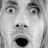

In [11]:
from IPython.display import display

def display_random_image_from_class(directory, class_name):
    """Displays a random image from a specified class within a directory."""
    class_path = os.path.join(directory, class_name)
    if os.path.exists(class_path):
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if image_files:
            random_image = random.choice(image_files)
            image_path = os.path.join(class_path, random_image)
            display(DisplayImage(filename=image_path))
        else:
            print(f"No images found in the '{class_name}' class.")
    else:
        print(f"The directory '{class_path}' does not exist.")

# Display a random image from the 'surprise' class in the test set
display_random_image_from_class(test_dir, 'surprise')



# Data Augmentation and Data Generators
To improve generalization, we apply a set of augmentations only to the training set.
Validation and Test sets are only rescaled.


In [12]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2

class RandomErasing(ImageOnlyTransform):
    def __init__(self, p=0.5):
        super().__init__(p=p)

    def apply(self, img, **params):
        h, w = img.shape[:2]
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)
        patch_w = np.random.randint(10, 30)
        patch_h = np.random.randint(10, 30)

        x2 = np.clip(x + patch_w, 0, w)
        y2 = np.clip(y + patch_h, 0, h)

        img[y:y2, x:x2] = 0
        return img

train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    RandomErasing(p=0.3),
])

def albumentations_augmentor(img):
    """
    img: a single 48x48 grayscale image (float32). Handles either 0-1 or 0-255 inputs.
    Keras passes img as HxWxc.
    """
    img_01 = img if img.max() <= 1.0 else img / 255.0
    img_uint8 = (img_01 * 255).astype('uint8')
    augmented = train_aug(image=img_uint8)['image']
    return augmented.astype('float32') / 255.0

train_datagen = ImageDataGenerator(
    preprocessing_function=albumentations_augmentor
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)


/home/chaki/mlenv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Found 21855 images belonging to 6 classes.
Found 3849 images belonging to 6 classes.
Found 6440 images belonging to 6 classes.



## CNN Model Architecture
This is a simple but effective CNN for facial emotion recognition.


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Sequential

# model = Sequential([
#     Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)),
#     BatchNormalization(), Activation('relu'), MaxPooling2D(),
#     Dropout(0.2),

#     Conv2D(128, (3,3), padding='same'),
#     BatchNormalization(), Activation('relu'), MaxPooling2D(),
#     Dropout(0.2),

#     Conv2D(256, (3,3), padding='same'),
#     BatchNormalization(), Activation('relu'), MaxPooling2D(),
#     Dropout(0.3),

#     Conv2D(512, (3,3), padding='same'),
#     BatchNormalization(), Activation('relu'), MaxPooling2D(),
#     Dropout(0.3),

#     GlobalAveragePooling2D(),

#     Dense(512, activation='relu'),
#     Dropout(0.3),  # lighter dropout
#     Dense(7, activation='softmax')
# ])


# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()


In [13]:
# Optional: mixed precision for faster training (set before building the model)
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy:", mixed_precision.global_policy())


Mixed precision policy: <DTypePolicy "mixed_float16">


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Input, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras import metrics as km

num_classes = train_generator.num_classes

# Define the squeeze-and-excitation block
def se_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block to improve feature selection."""
    channels = input_tensor.shape[-1]
    reduced_channels = max(1, channels // ratio)

    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(reduced_channels, activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)

    return Multiply()([input_tensor, x])

# Define a ResNet block with a proper shortcut connection
def resnet_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001))(x)
    x = Conv2D(filters, (3, 3), padding='same',
               kernel_regularizer=l2(0.0001))(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)

    x = Add()([x, shortcut])
    return Activation('relu')(x)

# Input Layer
input_layer = Input(shape=(48, 48, 1))

x = Conv2D(64, (3,3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

x = resnet_block(x, 128)  # Residual Block
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

x = resnet_block(x, 256)  # Residual Block
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = resnet_block(x, 512)  # Residual Block
x = Conv2D(1024, (3,3), padding='same', activation='relu')(x)
x = Conv2D(1024, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.4)(x)

x = se_block(x)  # Apply SE Block here

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax', dtype='float32')(x)

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

metrics = [
    'accuracy',
    km.Precision(name='precision'),
    km.Recall(name='recall'),
]

# Compile
model.compile(optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-4),
              loss='categorical_crossentropy',
              metrics=metrics)

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │    147,584 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      8,320 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ conv2d_2[0][0],   │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 12,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │     33,024 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 12, 12,    │          0 │ conv2d_5[0][0], 

 Total params: 19,638,342 (74.91 MB)

 Trainable params: 19,638,214 (74.91 MB)

 Non-trainable params: 128 (512.00 B)

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model):
    """Compute FLOPs of a TensorFlow Keras model."""
    # Convert Keras model to Concrete Function
    concrete_func = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), dtype=tf.float32)
    )

    # Convert to frozen concrete function
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph = frozen_func.graph.as_graph_def()

    # Use TensorFlow Profiler to get FLOPs
    with tf.compat.v1.Session() as sess:
        tf.compat.v1.import_graph_def(frozen_graph, name="")
        flops = tf.compat.v1.profiler.profile(
            sess.graph,
            options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        )

    return flops.total_float_ops

# Compute FLOPs
try:
    flops = get_flops(model)
    params = model.count_params()
    print(f"Total FLOPs: {flops / 1e9:.2f} GFLOPs")  # Convert to GFLOPs
    print(f"Total Parameters: {params / 1e6:.2f}M")  # Convert to Millions
except Exception as e:
    print(f"FLOPs Calculation Error: {e}")


I0000 00:00:1763843572.682134    7138 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1763843572.682975    7138 single_machine.cc:376] Starting new session
I0000 00:00:1763843572.685994    7138 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1763843576.491150    7138 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model g

In [17]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pick one class from train_dir
first_class = os.listdir(train_dir)[0]
first_class_path = os.path.join(train_dir, first_class)

# Load the first image in that class
first_image = os.listdir(first_class_path)[0]
img_path = os.path.join(first_class_path, first_image)

# Load image (48x48 grayscale)
img = load_img(img_path, color_mode='grayscale', target_size=(48, 48))
img_array = img_to_array(img) / 255.0   # normalize
real_input = np.expand_dims(img_array, axis=0)  # shape = (1,48,48,1)

In [18]:
# Map class folders to label indices
class_names = sorted(os.listdir(train_dir))
label_to_index = {name: idx for idx, name in enumerate(class_names)}

real_label = np.array([label_to_index[first_class]])   # shape (1,)

In [19]:
with tf.GradientTape() as tape:
    y_pred = model(real_input, training=True)
    loss = tf.keras.losses.sparse_categorical_crossentropy(real_label, y_pred)
    loss = tf.reduce_mean(loss)

grads = tape.gradient(loss, model.trainable_variables)

# Compute gradient norms
grad_norms = [tf.norm(g).numpy() for g in grads if g is not None]

print(f"Mean Gradient Norm: {np.mean(grad_norms):.6f}")
print(f"Max Gradient Norm: {np.max(grad_norms):.6f}")

if np.mean(grad_norms) < 1e-4:
    print("Vanishing Gradient Warning")
elif np.max(grad_norms) > 100:
    print("Exploding Gradient Warning")
else:
    print("Gradients look healthy.")


2025-11-22 15:36:32.193708: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-11-22 15:36:32.231880: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


Mean Gradient Norm: 1.715115
Max Gradient Norm: 15.087497
Gradients look healthy.


2025-11-22 15:38:42.610113: I external/local_xla/xla/service/service.cc:163] XLA service 0x762fd8005210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-22 15:38:42.610175: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-22 15:38:42.660710: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1763843923.725314    7242 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


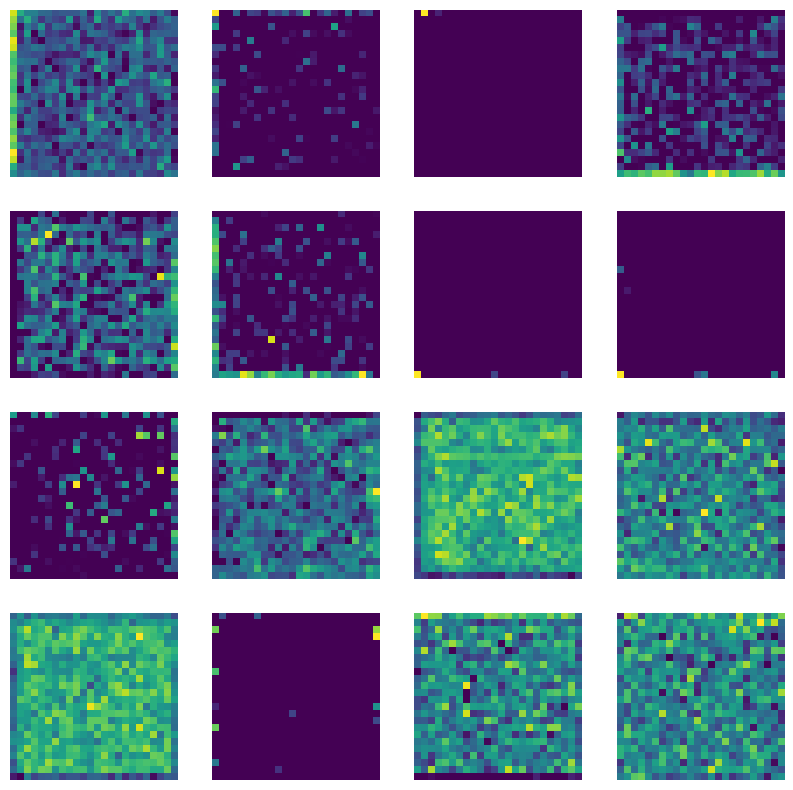

In [20]:
import matplotlib.pyplot as plt

def visualize_feature_maps(model, layer_name, image):
    """Visualizes the feature maps of a specific layer."""
    layer_output = model.get_layer(layer_name).output
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)

    activations = activation_model.predict(image[np.newaxis, :, :, np.newaxis])

    num_filters = activations.shape[-1]
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Display up to 16 feature maps

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            ax.imshow(activations[0, :, :, i], cmap='viridis')
        ax.axis('off')

    plt.show()

# Test with a random image (replace with an actual test image)
sample_image = np.random.rand(48, 48)  # Replace with real test image if available
visualize_feature_maps(model, "conv2d_1", sample_image)


Using conv for Grad-CAM: conv2d_11


/home/chaki/mlenv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)


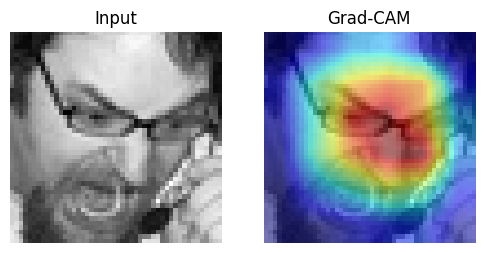

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        pred_output = predictions[:, pred_index]

    grads = tape.gradient(pred_output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Use absolute pooled grads to reduce zero-heatmaps
    heatmap = tf.reduce_sum(tf.abs(pooled_grads) * conv_outputs, axis=-1)
    heatmap = tf.where(tf.math.is_finite(heatmap), heatmap, 0.0)
    heatmap = tf.maximum(heatmap, 0.0)
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-6)
    return heatmap.numpy()

# Explicitly pick the deepest spatial conv layer
last_conv_layer_name = 'conv2d_11'
print('Using conv for Grad-CAM:', last_conv_layer_name)

# Build heatmap for one test sample
img, label = test_generator[0][0][0], test_generator[0][1][0]
img_input = img[np.newaxis, ...]  # (1, 48, 48, 1)

heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
heatmap = np.nan_to_num(heatmap, nan=0.0, posinf=0.0, neginf=0.0).astype('float32')

if heatmap.size == 0 or np.max(heatmap) == 0:
    print('Grad-CAM heatmap is invalid (zero/empty).')
else:
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (48, 48)).numpy().squeeze()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title('Input')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(heatmap_resized, alpha=0.5, cmap='jet')
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step 
Layer conv2d: 35 dead filters out of 64
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
Layer conv2d_1: 24 dead filters out of 128
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 
Layer conv2d_2: 74 dead filters out of 128
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 
Layer conv2d_3: 71 dead filters out of 128
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Layer conv2d_4: 39 dead filters out of 256
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Layer conv2d_5: 136 dead filters out of 256
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Layer conv2d_6: 129 dead filters out of 256
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Layer conv2d_7: 65 dead filters out of 512
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Layer conv2d_8: 271 dead filters out of 512
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Layer conv2d_9: 251 dead filters out of 512
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Layer conv2d_10: 110 dead filters out of 1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Layer conv2d_11: 101 dead filters out of 1024
2/2 ━━━━━━━━━━━━━

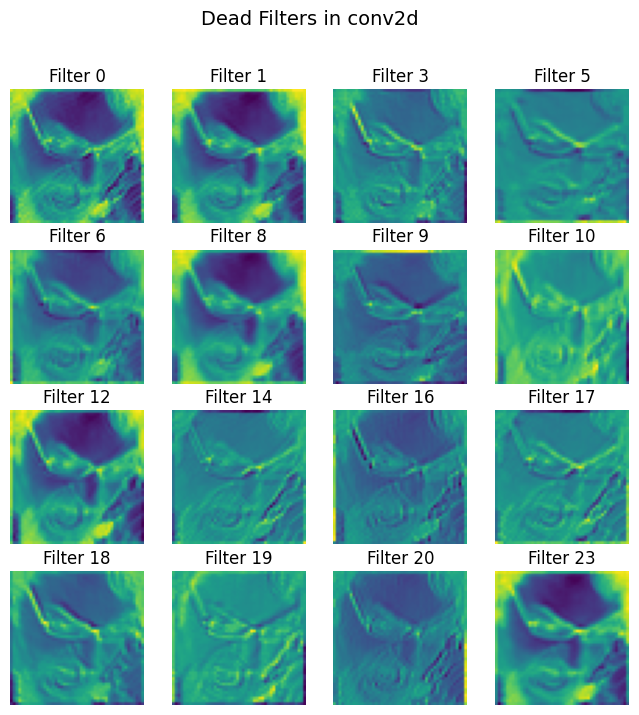

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Select a random batch of images from the test set
sample_images, _ = next(iter(test_generator))  # Get images without labels

# Define a function to extract activations
def get_activations(model, layer_name, images):
    layer_output = model.get_layer(layer_name).output
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)
    return activation_model.predict(images)

# Analyze activations for each Conv layer
dead_filters = {}
threshold = 1e-4  # Threshold for identifying dead filters

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer_name = layer.name
        activations = get_activations(model, layer_name, sample_images)

        # Compute the mean activation per filter
        mean_activations = np.mean(activations, axis=(0, 1, 2))  # Avg over spatial dims
        dead_filter_indices = np.where(mean_activations < threshold)[0]

        if len(dead_filter_indices) > 0:
            dead_filters[layer_name] = dead_filter_indices
            print(f"Layer {layer_name}: {len(dead_filter_indices)} dead filters out of {layer.filters}")

# Visualize dead vs active filters from the first Conv layer
conv_layer_name = list(dead_filters.keys())[0]  # Choose first conv layer with dead filters
activations = get_activations(model, conv_layer_name, sample_images)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
for i, idx in enumerate(dead_filters[conv_layer_name][:16]):  # Show 16 dead filters
    axes[i].imshow(activations[0, :, :, idx], cmap='viridis')
    axes[i].set_title(f"Filter {idx}")
    axes[i].axis('off')

plt.suptitle(f"Dead Filters in {conv_layer_name}", fontsize=14)
plt.show()


In [26]:
import tensorflow as tf
import numpy as np

def reinitialize_dead_filters(model, dead_filters):
    for layer_name, dead_indices in dead_filters.items():
        layer = model.get_layer(layer_name)

        # Get existing weights (kernel and bias)
        kernel, bias = layer.get_weights()

        # Get shape of kernel and bias
        kernel_shape = kernel.shape
        bias_shape = bias.shape

        # Generate new random weights for dead filters using Glorot Uniform (Xavier) Initialization
        initializer = tf.keras.initializers.GlorotUniform()
        new_kernel_weights = initializer(kernel_shape)
        new_bias_weights = tf.keras.initializers.Zeros()(bias_shape)

        # Convert NumPy array indices to list if necessary
        dead_indices = dead_indices.tolist() if isinstance(dead_indices, np.ndarray) else dead_indices

        # Update only the dead filters
        kernel[:, :, :, dead_indices] = new_kernel_weights.numpy()[:, :, :, dead_indices]
        bias[dead_indices] = new_bias_weights.numpy()[dead_indices]

        # Set updated weights back to the layer
        layer.set_weights([kernel, bias])

    print("Dead filters reinitialized!")

# Apply the fix
reinitialize_dead_filters(model, dead_filters)


Dead filters reinitialized!


In [27]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.momentum = 0.8  # Default is 0.99, reducing it stabilizes updates



## Training the Model
We use EarlyStopping and ReduceLROnPlateau to handle overfitting and dynamic learning rate adjustment.


In [28]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights once from the training data
class_indices = train_generator.class_indices
labels = train_generator.classes  # numeric labels per sample

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(train_generator.num_classes),
    y=labels
)

class_weight = {i: w for i, w in enumerate(weights)}

print("Computed class weights:")
for cls_idx, w in class_weight.items():
    print(f"  {list(class_indices.keys())[cls_idx]}: {w:.4f}")


Computed class weights:
  angry: 1.1571
  fear: 1.1792
  happy: 0.6189
  neutral: 0.9038
  sad: 0.9302
  surprise: 2.0383


In [29]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
import numpy as np

class CyclicLR(Callback):
    def __init__(self, base_lr=1e-5, max_lr=3e-4, step_size=2000):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.iterations = 0
        self.lrs = []

    def on_train_batch_begin(self, batch, logs=None):
        self.iterations += 1
        new_lr = self.base_lr + (self.max_lr - self.base_lr) *                  (1 + np.cos(self.iterations / self.step_size * np.pi)) / 2

        optimizer = self.model.optimizer
        lr_attr = getattr(optimizer, 'learning_rate', None)

        if hasattr(lr_attr, 'assign'):
            lr_attr.assign(new_lr)
        else:
            print("Warning: Learning rate is not assignable, skipping update.")

        self.lrs.append(new_lr)

clr = CyclicLR(base_lr=1e-5, max_lr=3e-4, step_size=2000)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

callbacks = [early_stopping, clr]


In [30]:
print(f"Active Callbacks: {[cb.__class__.__name__ for cb in callbacks]}")

Active Callbacks: ['EarlyStopping', 'CyclicLR']


In [31]:
print(f"Optimizer Type: {type(model.optimizer)}")

Optimizer Type: <class 'keras.src.optimizers.loss_scale_optimizer.LossScaleOptimizer'>


In [32]:
# Train the model
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight
)


Epoch 1/60


2025-11-22 15:59:40.736098: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-22 15:59:51.080879: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng1{k2=3,k3=0} for conv (f16[64,6,6,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,6,6,1024]{3,2,1,0}, f16[1024,3,3,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-22 15:59:51.278281: E external/local_xla/xla/service/slow_opera

336/342 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1427 - loss: 1.9959 - precision: 0.1175 - recall: 0.0020

2025-11-22 16:02:38.785221: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2903', 32 bytes spill stores, 32 bytes spill loads

2025-11-22 16:03:00.982890: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f16[128,3,3,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,24,24,128]{3,2,1,0}, f16[31,24,24,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-22 16:03:01.874689: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.893370696s
Trying algorithm eng0{} for conv (f

342/342 ━━━━━━━━━━━━━━━━━━━━ 308s 462ms/step - accuracy: 0.1536 - loss: 1.9206 - precision: 0.1081 - recall: 3.6605e-04 - val_accuracy: 0.2117 - val_loss: 1.8766 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
342/342 ━━━━━━━━━━━━━━━━━━━━ 76s 222ms/step - accuracy: 0.1767 - loss: 1.8611 - precision: 1.0000 - recall: 4.5756e-05 - val_accuracy: 0.2333 - val_loss: 1.8300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
342/342 ━━━━━━━━━━━━━━━━━━━━ 75s 219ms/step - accuracy: 0.2098 - loss: 1.8335 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2489 - val_loss: 1.8098 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
342/342 ━━━━━━━━━━━━━━━━━━━━ 75s 220ms/step - accuracy: 0.2345 - loss: 1.8086 - precision: 0.3158 - recall: 5.4907e-04 - val_accuracy: 0.3061 - val_loss: 1.7348 - val_precision: 1.0000 - val_recall: 2.5981e-04
Epoch 5/60
342/342 ━━━━━━━━━━━━━━━━━━━━ 75s 220ms/step - accuracy: 0.2945 - loss: 1.7369 - precision: 0.6397 -

 Train and validation accuracy of the final epoch to monitor Overfitting


In [33]:
print(history.history['accuracy'][-1], history.history['val_accuracy'][-1])

0.6627316474914551 0.637048602104187


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step


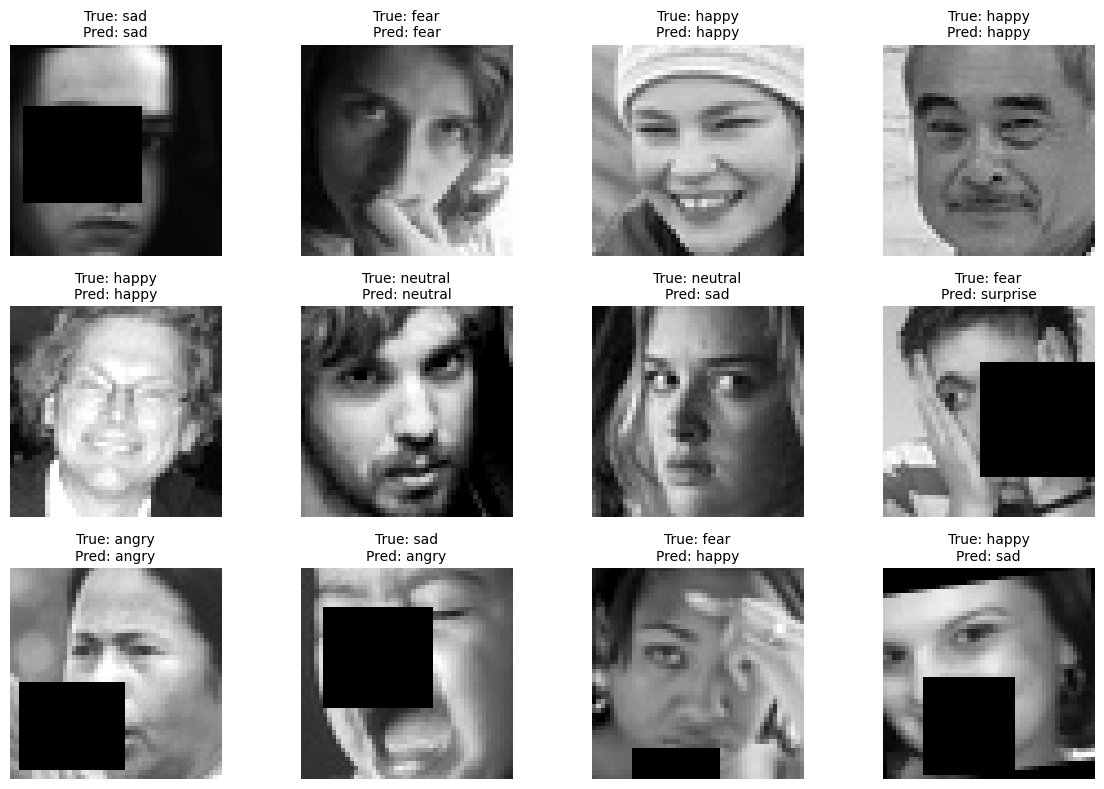

In [34]:
# Get 1 batch (64 images) from train_generator
images, true_labels = train_generator.__next__()

# Predict using the trained model
predictions = model.predict(images)

# Invert the class_indices dictionary
class_indices = train_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(12, 8))

for i in range(12):  # Show first 12 images
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')

    # Get true and predicted class
    true_class_index = np.argmax(true_labels[i])
    predicted_class_index = np.argmax(predictions[i])

    true_class_name = indices_to_class[true_class_index]
    predicted_class_name = indices_to_class[predicted_class_index]

    # Show both labels (True and Predicted)
    plt.title(f"True: {true_class_name}\nPred: {predicted_class_name}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Final Evaluation on Test Set
After training, we evaluate on the completely unseen test set.
We also compute a confusion matrix and classification report to measure **per-class performance**.


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


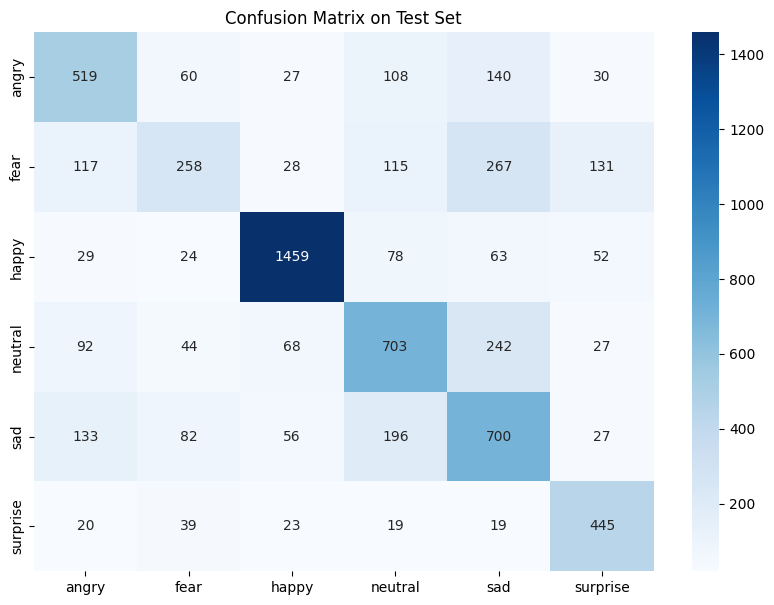

Classification Report:
              precision    recall  f1-score   support

       angry       0.57      0.59      0.58       884
        fear       0.51      0.28      0.36       916
       happy       0.88      0.86      0.87      1705
     neutral       0.58      0.60      0.59      1176
         sad       0.49      0.59      0.53      1194
    surprise       0.62      0.79      0.70       565

    accuracy                           0.63      6440
   macro avg       0.61      0.62      0.60      6440
weighted avg       0.63      0.63      0.63      6440

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6342 - loss: 1.0479 - precision: 0.7413 - recall: 0.5107
Train Accuracy: 66.27%
Validation Accuracy: 63.73%
Test Accuracy: 63.42%


In [36]:
# Predict on test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix on Test Set')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Final Accuracy Summary
train_acc = max(history.history['accuracy'])
val_acc = max(history.history['val_accuracy'])
loss, test_acc, test_prec, test_rec = model.evaluate(test_generator)
print(f"Train Accuracy: {train_acc:.2%}")
print(f"Validation Accuracy: {val_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")


In [37]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")


Macro F1 Score: 0.6042
Weighted F1 Score: 0.6277


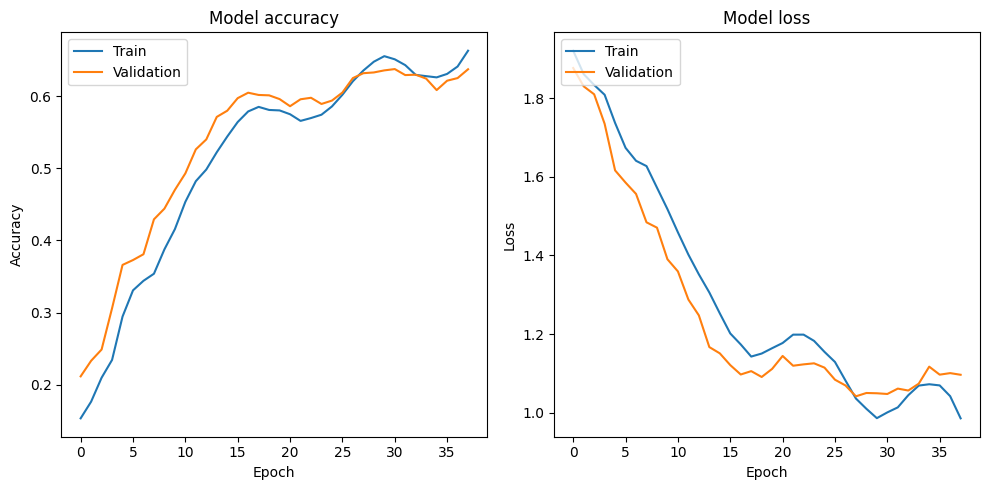

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [46]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # enable TF Select (Flex) ops
]
tflite_model = converter.convert()

W0000 00:00:1763862293.546230    7138 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1763862293.546346    7138 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-22 20:44:53.546703: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model_exports/fer_savedmodel_20251122_165651
2025-11-22 20:44:53.549456: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-22 20:44:53.549471: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: model_exports/fer_savedmodel_20251122_165651
2025-11-22 20:44:53.568269: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-22 20:44:53.776805: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: model_exports/fer_savedmodel_20251122_165651
2025-11-22 20:44:53.808412: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status:

In [47]:
import os
import json
import datetime
import tensorflow as tf

# Create local folder for outputs
output_root = "model_exports"
os.makedirs(output_root, exist_ok=True)

# Timestamp
formatted_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# -------------------------------
# 1. Save class index mapping
# -------------------------------
class_indices = train_generator.class_indices
class_indices_path = os.path.join(output_root, f"fer_class_indices_{formatted_datetime}.json")

with open(class_indices_path, "w") as f:
    json.dump(class_indices, f)

print("Class indices saved:", class_indices_path)



# -------------------------------
# 2. Export TensorFlow SavedModel
# (Keras 3 uses model.export, not model.save)
# -------------------------------
saved_model_dir = os.path.join(output_root, f"fer_savedmodel_{formatted_datetime}")
model.export(saved_model_dir)
print("SavedModel exported to:", saved_model_dir)

# -------------------------------
# 3. Convert SavedModel → TFLite
# -------------------------------
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]
# tflite_model = converter.convert()
# tflite_path = os.path.join(output_root, f"fer_model_{formatted_datetime}.tflite")
# with open(tflite_path, "wb") as f:
#     f.write(tflite_model)
# print("TFLite model saved:", tflite_path)

# -------------------------------
# 4. Save Keras model (.keras)
# -------------------------------
keras_path = os.path.join(output_root, f"fer_model_{formatted_datetime}.keras")
try:
    model.save(keras_path)
    print("Keras model saved:", keras_path)
except Exception as e:
    print(f"Error saving .keras model: {e}")

# -------------------------------
# 5. Save H5 model (.h5)
# -------------------------------
h5_path = os.path.join(output_root, f"fer_model_{formatted_datetime}.h5")
try:
    model.save(h5_path)
    print("H5 model saved:", h5_path)
except Exception as e:
    print(f"Error saving .h5 model: {e}")


Class indices saved: model_exports/fer_class_indices_20251122_204817.json
INFO:tensorflow:Assets written to: model_exports/fer_savedmodel_20251122_204817/assets


INFO:tensorflow:Assets written to: model_exports/fer_savedmodel_20251122_204817/assets


Saved artifact at 'model_exports/fer_savedmodel_20251122_204817'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  129944852708624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129953359081552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944838768400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944852709008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944852709200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944838768016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944838767440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944838768208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944838769744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129944838769360: TensorSpec(shape=(), dtype=tf.resource, n

Keras model saved: model_exports/fer_model_20251122_204817.keras
H5 model saved: model_exports/fer_model_20251122_204817.h5


In [48]:
import os
import tensorflow as tf

# Ensure output directory exists
os.makedirs(output_root, exist_ok=True)

try:
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()
    if tflite_model is None:
        raise ValueError("TFLite conversion returned None. Check model compatibility and conversion logs.")
    tflite_path = os.path.join(output_root, f"fer_model_{formatted_datetime}.tflite")
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    print("TFLite model saved:", tflite_path)
except Exception as e:
    print("Error during TFLite conversion or saving:", e)

W0000 00:00:1763862586.601013    7138 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1763862586.601136    7138 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-22 20:49:46.601472: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model_exports/fer_savedmodel_20251122_204817
2025-11-22 20:49:46.604764: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-22 20:49:46.604780: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: model_exports/fer_savedmodel_20251122_204817
2025-11-22 20:49:46.627270: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-22 20:49:46.871245: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: model_exports/fer_savedmodel_20251122_204817
2025-11-22 20:49:46.911111: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status:

TFLite model saved: model_exports/fer_model_20251122_204817.tflite


In [45]:
# GPU Verification Script (run after activating py312 venv and installing TF)
import os, sys, subprocess, time, platform
print('=== Python / Platform ===')
print(sys.version)
print(platform.platform())

print('\n=== CUDA Toolkit Detection ===')
for v in ['v12.6','v13.0']:
    base = f'C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/{v}'
    print(v, 'exists' if os.path.isdir(base) else 'missing')
    nvcc = os.path.join(base,'bin','nvcc.exe')
    if os.path.isfile(nvcc):
        try:
            out = subprocess.check_output([nvcc,'--version'], text=True, timeout=5)
            print(f'{v} nvcc version:\n{out.strip()}')
        except Exception as e:
            print(f'{v} nvcc query failed:', e)
    else:
        print(f'{v} nvcc.exe not found')

print('\n=== cuDNN DLL Check (v12.6) ===')
cudnn_dll = 'C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.6/bin/cudnn64_9.dll'
print('cuDNN DLL present:', os.path.isfile(cudnn_dll))

print('\n=== Environment PATH CUDA Entries ===')
path_entries = [p for p in os.environ.get('PATH','').split(';') if 'CUDA' in p]
for p in path_entries:
    print(p)

print('\n=== TensorFlow Device Enumeration ===')
try:
    import tensorflow as tf
    print('TensorFlow version:', tf.__version__)
    print('Built with CUDA:', tf.test.is_built_with_cuda())
    gpus = tf.config.list_physical_devices('GPU')
    print('Physical GPUs:', gpus)
    if gpus:
        # memory growth
        for g in gpus:
            try:
                tf.config.experimental.set_memory_growth(g, True)
            except Exception as e:
                print('Memory growth fail for', g, e)
        # simple compute timing
        import numpy as np
        A = tf.random.uniform((2048,2048))
        B = tf.random.uniform((2048,2048))
        t0 = time.time(); C = tf.matmul(A,B); _ = C.numpy(); dt = time.time()-t0
        print(f'MatMul 2048x2048 time: {dt:.3f}s (GPU expected < CPU)')
    else:
        print('No GPU visible to TensorFlow. Verify you are in py312 venv (gpuenv) and installed tensorflow==2.20.0.')
except Exception as e:
    print('TensorFlow import failed:', e)
    print('Likely wrong Python version (need 3.12) or missing TF install in this venv.')

print('\n=== Next Steps If GPU Missing ===')
print('1. Activate venv:   .\\gpuenv\\Scripts\\activate')
print('2. Install TF:      pip install tensorflow==2.20.0')
print('3. Re-run this cell.')


=== Python / Platform ===
3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39

=== CUDA Toolkit Detection ===
v12.6 missing
v12.6 nvcc.exe not found
v13.0 missing
v13.0 nvcc.exe not found

=== cuDNN DLL Check (v12.6) ===
cuDNN DLL present: False

=== Environment PATH CUDA Entries ===
/home/chaki/mlenv/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/wsl/lib:/mnt/c/Program Files/WindowsApps/MicrosoftCorporationII.WindowsSubsystemForLinux_2.6.1.0_x64__8wekyb3d8bbwe:/mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.6/bin:/mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.6/libnvvp:/mnt/c/Windows/system32:/mnt/c/Windows:/mnt/c/Windows/System32/Wbem:/mnt/c/Windows/System32/WindowsPowerShell/v1.0/:/mnt/c/Windows/System32/OpenSSH/:/mnt/c/Program Files/dotnet/:/mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common:/mnt/c/Program Files/NVIDIA Corporation/NVIDIA Nv